# Earthdata Webinar: Examining Hurricane Milton's Milestones with NASA's GES DISC Datasets

Author: Chris Battisto (christopher.m.battisto@nasa.gov)

Attendee:

### Overview




### Prerequisites

- A valid [Earthdata Login account](https://urs.earthdata.nasa.gov/)
    - Approval of the "NASA GESDISC DATA ARCHIVE" application by following this guide: https://disc.gsfc.nasa.gov/earthdata-login
    - Generation of the `.netrc` and `.dodsrc` files (both files will be generated in this notebook)
- Python >=3.9
- [Xarray](https://docs.xarray.dev/en/stable/)
- [Pandas](https://pandas.pydata.org/)
- [Matplotlib](https://matplotlib.org/)
- [Cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [NumPy](https://numpy.org/)
- [earthaccess](https://github.com/nsidc/earthaccess)


You can run this tutorial in your browser using Colab:<br>

<a target="_blank" href="https://colab.research.google.com/nasa/gesdisc-tutorials/blob/main/webinars/14_November_2023_Carpentries_Skill-Up/November_14th_Carpentries_Demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### 1. Install Packages and Import Libraries

In [1]:
import earthaccess
import requests
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### 2. Authenticate with Earthdata Login Servers

In [13]:
# persist=True will prompt for an Earthdata login/password
auth = earthaccess.login(persist=True)

### 2. Search for GPM_2ADPR Granules

TROPICS03MIRSL2B_1.0
TROPICS06MIRSL2B_1.0
TROPICS03PRPSL2B_1.0
TROPICS06PRPSL2B_1.0
TROPICS03URADL2A_1.0
TROPICS06URADL2A_1.0
TROPICS03TCIEL2B_1.0
TROPICS06TCIEL2B_1.0

In [126]:
# To download multiple files, change the second temporal parameter
results = earthaccess.search_data(
    short_name="GPM_2ADPR",   # Replace with the correct short name
    version="07",
    granule_ur="GPM_2ADPR.07:2A.GPM.DPR.V9-20240130.20241008-S191016-E204329.060264.V07C.HDF5"
)

print(len(results))
results[0]

1


Collection: {'ShortName': 'GPM_2ADPR', 'Version': '07'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 177.28642, 'Latitude': -65.79003}, {'Longitude': -151.71802, 'Latitude': -62.07776}, {'Longitude': -153.08316, 'Latitude': -60.8615}, {'Longitude': 177.2319, 'Latitude': -64.41028}, {'Longitude': 177.28642, 'Latitude': -65.79003}]}}, {'Boundary': {'Points': [{'Longitude': -151.72156, 'Latitude': -62.07816}, {'Longitude': -131.39296, 'Latitude': -53.14914}, {'Longitude': -133.05289, 'Latitude': -52.20791}, {'Longitude': -153.15781, 'Latitude': -60.88295}, {'Longitude': -151.72156, 'Latitude': -62.07816}]}}, {'Boundary': {'Points': [{'Longitude': -131.40066, 'Latitude': -53.15076}, {'Longitude': -119.09297, 'Latitude': -41.8172}, {'Longitude': -120.6364, 'Latitude': -41.08147}, {'Longitude': -133.09285, 'Latitude': -52.24082}, {'Longitude': -131.40066, 'Latitude': -53.15076}]}}, {'Boundary': {'Points': [{'Longitude': -119.10277, 'Latitude': -41.82204}, {'Longitude': -110.89778, 'Latitude': -29.42342}, {'Longitude': -112.29328, 'Latitude': -28.81869}, {'Longitude': -120.65619, 'Latitude': -41.11701}, {'Longitude': -119.10277, 'Latitude': -41.82204}]}}, {'Boundary': {'Points': [{'Longitude': -110.90798, 'Latitude': -29.43307}, {'Longitude': -104.6933, 'Latitude': -16.533}, {'Longitude': -105.98751, 'Latitude': -16.00494}, {'Longitude': -112.30346, 'Latitude': -28.85268}, {'Longitude': -110.90798, 'Latitude': -29.43307}]}}, {'Boundary': {'Points': [{'Longitude': -104.703, 'Latitude': -16.54789}, {'Longitude': -99.35471, 'Latitude': -3.42852}, {'Longitude': -100.60354, 'Latitude': -2.93524}, {'Longitude': -105.99371, 'Latitude': -16.03477}, {'Longitude': -104.703, 'Latitude': -16.54789}]}}, {'Boundary': {'Points': [{'Longitude': -99.36375, 'Latitude': -3.44901}, {'Longitude': -94.14628, 'Latitude': 9.7006}, {'Longitude': -95.40552, 'Latitude': 10.19638}, {'Longitude': -100.60866, 'Latitude': -2.95992}, {'Longitude': -99.36375, 'Latitude': -3.44901}]}}, {'Boundary': {'Points': [{'Longitude': -94.15313, 'Latitude': 9.67402}, {'Longitude': -88.39217, 'Latitude': 22.67678}, {'Longitude': -89.724, 'Latitude': 23.2163}, {'Longitude': -95.41329, 'Latitude': 10.1784}, {'Longitude': -94.15313, 'Latitude': 9.67402}]}}, {'Boundary': {'Points': [{'Longitude': -88.401, 'Latitude': 22.64548}, {'Longitude': -81.20906, 'Latitude': 35.26762}, {'Longitude': -82.67231, 'Latitude': 35.90002}, {'Longitude': -89.73263, 'Latitude': 23.2039}, {'Longitude': -88.401, 'Latitude': 22.64548}]}}, {'Boundary': {'Points': [{'Longitude': -81.22405, 'Latitude': 35.23334}, {'Longitude': -71.08794, 'Latitude': 47.06076}, {'Longitude': -72.7151, 'Latitude': 47.85407}, {'Longitude': -82.68111, 'Latitude': 35.89271}, {'Longitude': -81.22405, 'Latitude': 35.23334}]}}, {'Boundary': {'Points': [{'Longitude': -71.11662, 'Latitude': 47.0268}, {'Longitude': -55.21644, 'Latitude': 57.16003}, {'Longitude': -56.86027, 'Latitude': 58.20281}, {'Longitude': -72.72284, 'Latitude': 47.85104}, {'Longitude': -71.11662, 'Latitude': 47.0268}]}}, {'Boundary': {'Points': [{'Longitude': -55.27216, 'Latitude': 57.13237}, {'Longitude': -29.88301, 'Latitude': 63.55505}, {'Longitude': -30.74387, 'Latitude': 64.87022}, {'Longitude': -56.86494, 'Latitude': 58.20211}, {'Longitude': -55.27216, 'Latitude': 57.13237}]}}, {'Boundary': {'Points': [{'Longitude': -29.97331, 'Latitude': 63.54409}, {'Longitude': 1.64418, 'Latitude': 63.4332}, {'Longitude': 2.46001, 'Latitude': 64.75365}, {'Longitude': -30.74488, 'Latitude': 64.86995}, {'Longitude': -29.97331, 'Latitude': 63.54409}]}}, {'Boundary': {'Points': [{'Longitude': 1.55487, 'Latitude': 63.44526}, {'Longitude': 26.63516, 'Latitude': 56.86503}, {'Longitude': 28.23461, 'Latitude': 57.92558}, {'Longitude': 2.45858, 'Latitude': 64.75355}, {'Longitude': 1.55487, 'Latitude': 63.44526}]}}, {'Boundary': {'Points': [{'Longitude': 26.58165, 'Latitude': 56.8935}, {'Longitude': 42.2504, 'Latitude

In [69]:
od_files = []

for itm in results:  # Iterate over items in the results list
    for urls in itm['umm']['RelatedUrls']:  # Iterate over RelatedUrls in each item
        if 'OPENDAP' in urls.get('Description', '').upper():  # Check if 'OPENDAP' is in the Description
            ce = ".dap.nc4?dap4.ce={}%3B{}%3B{}%3B{}".format("FS_SLV_precipRate", "FS_SLV_precipRateNearSurface", "FS_Longitude", "FS_Latitude")
            opendap_url = urls['URL'] + ce
            od_files.append(opendap_url)  # Add the URL to the list

print(od_files)

['https://gpm1.gesdisc.eosdis.nasa.gov/opendap/GPM_L2/GPM_2ADPR.07/2024/282/2A.GPM.DPR.V9-20240130.20241008-S051110-E064423.060255.V07C.HDF5.dap.nc4?dap4.ce=FS_SLV_precipRate%3BFS_SLV_precipRateNearSurface%3BFS_Longitude%3BFS_Latitude', 'https://gpm1.gesdisc.eosdis.nasa.gov/opendap/GPM_L2/GPM_2ADPR.07/2024/282/2A.GPM.DPR.V9-20240130.20241008-S191016-E204329.060264.V07C.HDF5.dap.nc4?dap4.ce=FS_SLV_precipRate%3BFS_SLV_precipRateNearSurface%3BFS_Longitude%3BFS_Latitude']


In [70]:
# Set the FILENAME string to the data file name, the LABEL keyword value, or any customized name. 
# Remember to include the same file extension as in the URL.

# Target directory for downloaded files
target_dir = "gpm_2adpr_subsets"

# Create the directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Download each file
for fn in od_files:
    # Extract the file name from the URL
    FILENAME = os.path.join(target_dir, os.path.basename(fn + '.nc4'))
    
    result = requests.get(fn)
    try:
        result.raise_for_status()
        f = open(FILENAME, 'wb')
        f.write(result.content)
        f.close()
        #print('Contents of URL written to ' + FILENAME)
    except:
        print('requests.get() returned an error code ' + str(result.status_code))
        raise

In [92]:
ds = xr.open_mfdataset('gpm_2adpr_subsets/*.nc4', combine="nested", concat_dim="nscan")

pr   = ds['FS_SLV_precipRate']
prns = ds['FS_SLV_precipRateNearSurface']
lon  = ds["FS_Longitude"]
lat  = ds["FS_Latitude"]

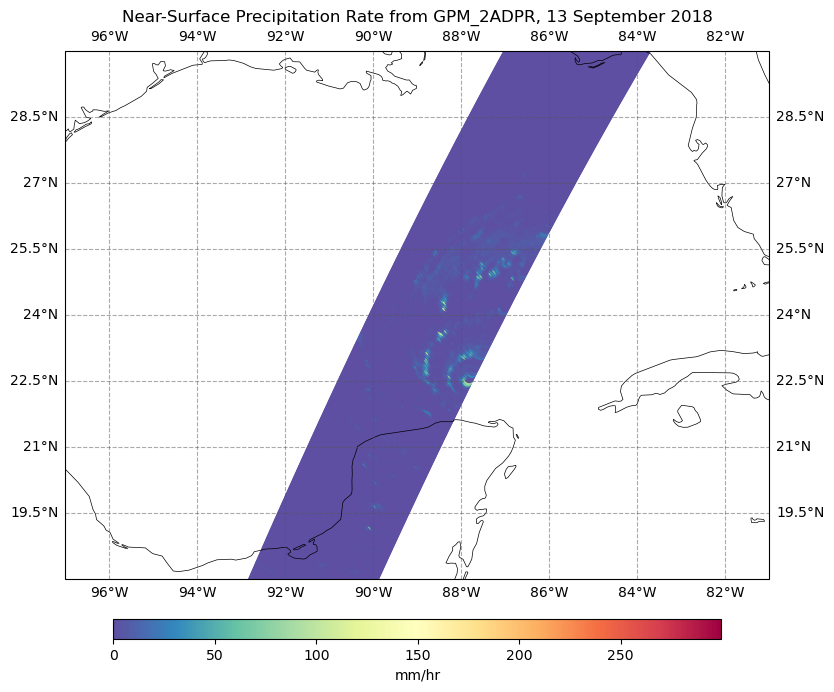

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Flatten the dataset dimensions to match latitude, longitude, and precipitation rate
lats = lat.values.flatten()
lons = lon.values.flatten()
prns = prns.values.flatten()

# Draw the subset of near-surface precipitation rate
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent for the plot (adjust for the region of interest, e.g., Gulf of Mexico)
ax.set_extent([-97, -81, 21, 27])  # Longitude: -97 to -81, Latitude: 18 to 30

plt.title('Near-Surface Precipitation Rate from GPM_2ADPR, 13 September 2018')

# Add coastlines and gridlines
ax.coastlines(resolution="50m", linewidth=0.5)
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.8,
    color="#555555",
    alpha=0.5,
    linestyle="--",
)
# Axis labels
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True

# Plot the scatter diagram
pp = plt.scatter(
    lons,
    lats,
    c=prns,
    cmap=plt.cm.Spectral_r,
    transform=ccrs.PlateCarree(),
)

# Add a colorbar to the bottom of the plot
fig.subplots_adjust(bottom=0.15, left=0.06, right=0.94)
cbar_ax = fig.add_axes([0.12, 0.11, 0.76, 0.025])
cbar = plt.colorbar(pp, cax=cbar_ax, orientation="horizontal")
cbar.set_label(label=ds["FS_SLV_precipRateNearSurface"].attrs.get("units", "mm/hr"), size=10)

plt.show()


In [71]:
# ALONG-TRACK VERTICAL PROFILE
# Choose the range of the subset, e.g.:
#   170 rows in the along-track dimension,
#   One element in the cross-track dimension that slices through the eye of the storm
#   The lowest 76 elements in the vertical dimension

max_pr_dim = pr.max(dim=["nscan", "nbin"]).argmax(dim="nray").values.flatten()[0]

mysub2 = pr[:,48,100:176]

# Transpose the array so the along-track dimension will be the X-Axis
#   and the vertical dimension will be the Y-Axis
subset2 = mysub2.transpose("nbin", "nscan")

In [72]:
# Define the bounding box for the Gulf of Mexico
lat_min, lat_max = 21, 27  # Latitude range
lon_min, lon_max = -97, -81  # Longitude range

# Compute latitude and longitude to ensure they're not lazy (Dask arrays)
latitudes = subset2['FS_Latitude'].compute()
longitudes = subset2['FS_Longitude'].compute()

# Apply the subset using the latitude and longitude bounds
subset_gulf = subset2.where(
    (latitudes >= lat_min) & (latitudes <= lat_max) &
    (longitudes >= lon_min) & (longitudes <= lon_max),
    drop=True
).compute()


/var/folders/97/gqmrw3hs0lv0cs_3ytv4v9480000gq/T/ipykernel_70096/2924483846.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


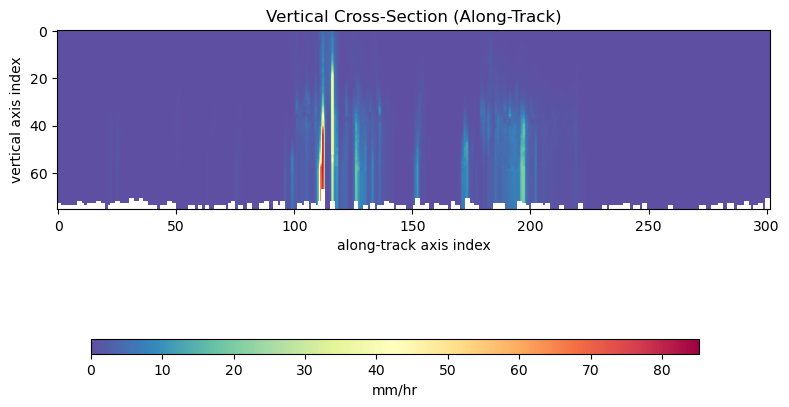

In [76]:
# Draw the ALONG-TRACK VERTICAL PROFILE
fig = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.set_xlabel('along-track axis index')
ax.set_ylabel('vertical axis index')
ax.set_title('Vertical Cross-Section (Along-Track)')

pp = plt.imshow(subset_gulf, cmap=plt.cm.Spectral_r)

# Add a colorbar to the bottom of the plot.
fig.subplots_adjust(bottom=0.15, left=0.06, right=0.94)
cbar_ax = fig.add_axes([0.12, 0.11, 0.76, 0.025])  
cbar = plt.colorbar(pp, cax=cbar_ax, orientation='horizontal')
cbar.set_label(label=pr.attrs.get('units'),size=10)

fig.tight_layout()



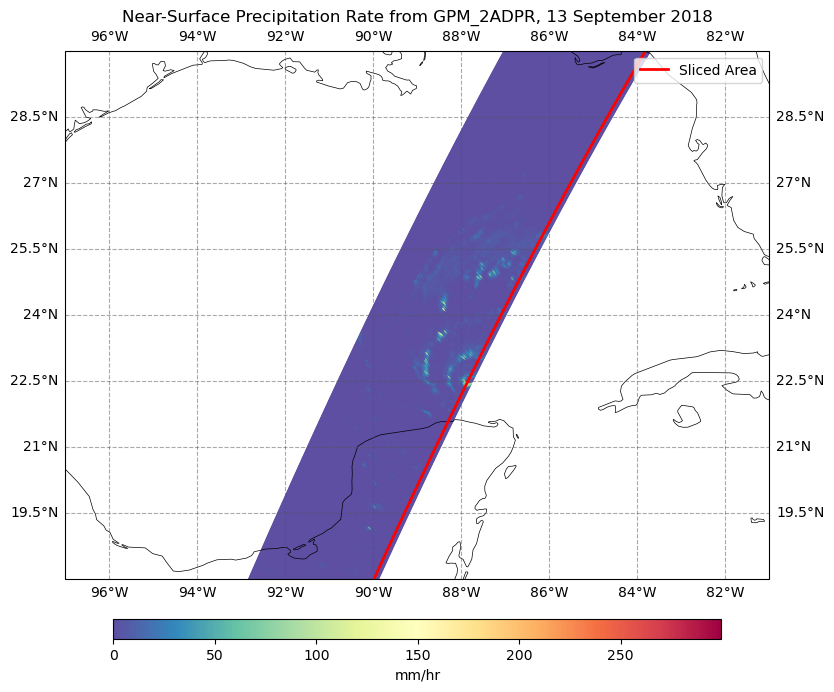

In [70]:
red_line_lon = ds['FS_Longitude'][:, 48].values
red_line_lat = ds['FS_Latitude'][:, 48].values

# Draw the subset of near-surface precipitation rate
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent for the plot (adjust for the region of interest, e.g., Gulf of Mexico)
ax.set_extent([-97, -81, 21, 27])  # Longitude: -97 to -81, Latitude: 18 to 30

plt.title('Near-Surface Precipitation Rate from GPM_2ADPR, 13 September 2018')

# Add coastlines and gridlines
ax.coastlines(resolution="50m", linewidth=0.5)
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.8,
    color="#555555",
    alpha=0.5,
    linestyle="--",
)
# Axis labels
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True

# Plot the scatter diagram
pp = plt.scatter(
    lon,
    lat,
    c=prns,  # Use the original filtered data
    cmap=plt.cm.Spectral_r,
    transform=ccrs.PlateCarree(),
)

# Add the red line indicating the cross-track slice
ax.plot(
    red_line_lon,
    red_line_lat,
    color="red",
    linewidth=2,
    transform=ccrs.PlateCarree(),
    label="Sliced Area"
)

# Add a legend
ax.legend(loc="upper right", fontsize=10)

# Add a colorbar to the bottom of the plot
fig.subplots_adjust(bottom=0.15, left=0.06, right=0.94)
cbar_ax = fig.add_axes([0.12, 0.11, 0.76, 0.025])
cbar = plt.colorbar(pp, cax=cbar_ax, orientation="horizontal")
cbar.set_label(label=ds["FS_SLV_precipRateNearSurface"].attrs.get("units", "mm/hr"), size=10)

plt.show()